In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')

In [3]:
na_percentage = (X_train.isna().mean() * 100).round(2)
na_percentage

id                           0.00
name                         0.00
has_test                     0.00
response_letter_required     0.00
salary_from                 14.43
salary_currency              0.00
salary_gross                 0.53
published_at                 0.00
created_at                   0.00
employer_name                0.00
description                  0.00
area_id                      0.00
area_name                    0.00
dtype: float64

In [4]:
# Добавляем новые фичи
X_train['name_length'] = X_train['name'].apply(len)
X_train['name_word_count'] = X_train['name'].apply(lambda x: len(x.split()))

In [5]:
X_test['name_length'] = X_test['name'].apply(len)
X_test['name_word_count'] = X_test['name'].apply(lambda x: len(x.split()))

In [6]:
# Убираем данные с пропущенными значениями salary_gross, т.к их не так много
X_train.dropna(subset=['salary_gross'], inplace=True)
X_train['salary_gross'] = X_train['salary_gross'].astype(bool)
X_train.dtypes

id                            int64
name                         object
has_test                       bool
response_letter_required       bool
salary_from                 float64
salary_currency              object
salary_gross                   bool
published_at                 object
created_at                   object
employer_name                object
description                  object
area_id                       int64
area_name                    object
name_length                   int64
name_word_count               int64
dtype: object

In [7]:
X_test['salary_gross'].fillna(X_train['salary_gross'].mode(), inplace=True)
X_test['salary_gross'] = X_test['salary_gross'].astype(bool)

X_test.dtypes

id                            int64
name                         object
has_test                       bool
response_letter_required       bool
salary_from                 float64
salary_currency              object
salary_gross                   bool
published_at                 object
created_at                   object
employer_name                object
description                  object
area_id                       int64
area_name                    object
name_length                   int64
name_word_count               int64
dtype: object

In [8]:
X_train['salary_currency'].unique()

array(['RUR'], dtype=object)

In [9]:
# Бесполезный признак
X_train.drop(columns=['salary_currency'], inplace=True)
X_test.drop(columns=['salary_currency'], inplace=True)

In [10]:
X_train['created_at'] = pd.to_datetime(X_train['created_at'])
X_train['published_at'] = pd.to_datetime(X_train['published_at'])

In [11]:
X_test['created_at'] = pd.to_datetime(X_test['created_at'])
X_test['published_at'] = pd.to_datetime(X_test['published_at'])

In [12]:
from nltk.corpus import stopwords
import nltk

stop_words = set(stopwords.words("english") + stopwords.words("russian"))
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/rpopov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Area_name

In [13]:
all_data = pd.concat([X_train, X_test])
all_encoded = pd.get_dummies(all_data['area_name'], prefix='area_name')

In [14]:
x_train_encoded = all_encoded.iloc[:len(X_train)]
df_train = pd.concat([X_train.drop(columns=['area_name']), x_train_encoded], axis=1)
df_train

,id,name,has_test,response_letter_required,salary_from,salary_gross,published_at,created_at,employer_name,description,...,area_name_Шадринск,area_name_Шахты,area_name_Шымкент,area_name_Эквадор,area_name_Энгельс,area_name_Эстония,area_name_Южно-Сахалинск,area_name_Якутск,area_name_Ялта,area_name_Ярославль
0,29083,Менеджер по продажам (брокер) элитной городско...,False,False,NaN,False,2020-06-16 06:45:04+00:00,2020-06-16 06:45:04+00:00,Villagio Estate,<strong>Обязанности:</strong> <p>​​​​​- Прием ...,...,0,0,0,0,0,0,0,0,0,0
1,26052,Product marketing manager / Продуктовый маркет...,False,False,120000.0,False,2020-07-22 10:24:15+00:00,2020-07-22 10:24:15+00:00,CityAds Media,<p><strong>CityAds Media</strong> – один из ли...,...,0,0,0,0,0,0,0,0,0,0
2,24055,Программист Python (Middle),False,False,NaN,False,2020-04-12 08:19:08+00:00,2020-04-12 08:19:08+00:00,Лендсбэй,<p>В перспективный международный Fintech старт...,...,0,0,0,0,0,0,0,0,0,0
3,4408,"Продавец-кассир (Москва, Вернадского, 93)",False,False,33500.0,True,2020-08-24 01:16:52+00:00,2020-08-24 01:16:52+00:00,Пятёрочка,<p><strong>Обязанности:</strong></p><ul><li>Об...,...,0,0,0,0,0,0,0,0,0,0
4,16856,Дизайнер-визуализатор,False,True,30000.0,True,2021-09-18 13:30:15+00:00,2021-09-18 13:30:15+00:00,Моллдекор Рус,<p><strong>Компания MALL DECOR</strong> - лиде...,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27929,16850,Директор департамента по административной и ка...,False,False,120000.0,False,2021-10-03 10:04:45+00:00,2021-10-03 10:04:45+00:00,Балтик Граунд Сервисес РУ,<p><em>Если вы ищете динамичную работу в расту...,...,0,0,0,0,0,0,0,0,0,0
27930,6265,"Продавец-кассир (г Москва, ул Смольная, д 67 к 2)",False,False,33500.0,True,2020-09-07 00:32:00+00:00,2020-09-07 00:32:00+00:00,Пятёрочка,<p><strong>Обязанности:</strong></p><ul><li>Об...,...,0,0,0,0,0,0,0,0,0,0
27931,11284,Младший аналитик данных,False,False,50000.0,False,2021-04-20 08:25:44+00:00,2021-04-20 08:25:44+00:00,Баскаков Дмитрий Владимирович,<p>Ищем перспективного и талантливого веб анал...,...,0,0,0,0,0,0,0,0,0,0
27932,860,Копирайтер / контент менеджер,False,False,60000.0,False,2020-11-15 11:12:07+00:00,2020-11-15 11:12:07+00:00,Revain,<p><strong>Обязанности:</strong></p> <p><stron...,...,0,0,0,0,0,0,0,0,0,0


In [15]:
x_test_encoded = all_encoded.iloc[len(X_train):]
df_test = pd.concat([X_test.drop(columns=['area_name']), x_test_encoded], axis=1)
df_test

,id,name,has_test,response_letter_required,salary_from,salary_gross,published_at,created_at,employer_name,description,...,area_name_Шадринск,area_name_Шахты,area_name_Шымкент,area_name_Эквадор,area_name_Энгельс,area_name_Эстония,area_name_Южно-Сахалинск,area_name_Якутск,area_name_Ялта,area_name_Ярославль
0,20978,Техник по инструменту / Специалист по инструме...,False,False,35000.0,False,2020-03-23 10:49:43+00:00,2020-03-23 10:49:43+00:00,АвтоСпецЦентр,<strong>Обязанности:</strong> <ul> <li>произво...,...,0,0,0,0,0,0,0,0,0,0
1,3102,Диспетчер по заказам,False,False,20000.0,False,2020-08-18 10:29:11+00:00,2020-08-18 10:29:11+00:00,АвтоВыкуп,<p>Приглашаем диспетчера по работе с заказами ...,...,0,0,0,0,0,0,0,0,0,0
2,14731,Frontend Developer в Focus Calendar,False,False,200000.0,False,2021-08-09 09:00:27+00:00,2021-08-09 09:00:27+00:00,Focus Calendar,<p><strong>Кого мы ищем и что тебе предстоит д...,...,0,0,0,0,0,0,0,0,0,0
3,16113,Системный аналитик,False,False,150000.0,False,2021-08-08 05:59:07+00:00,2021-08-08 05:59:07+00:00,INTECH,"<p>INTECH - IT-компания, ведущий контент и сер...",...,0,0,0,0,0,0,0,0,0,0
4,8410,Front-end разработчик (JavaScript),False,False,80000.0,False,2021-01-12 08:16:14+00:00,2021-01-12 08:16:14+00:00,Кравцов И.Н.,<p><strong>Требования к кандидату:</strong></p...,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9307,29490,Обходчик объекта,False,False,40000.0,False,2020-06-10 10:47:48+00:00,2020-06-10 10:47:48+00:00,МонтажСпецСтрой,"<p>ООО «Ремсервис»</p> <p>Москва, Текстильщики...",...,0,0,0,0,0,0,0,0,0,0
9308,34298,IT рекрутер (удаленно),False,False,40000.0,False,2020-11-17 08:25:30+00:00,2020-11-17 08:25:30+00:00,Soft personal,<p><strong>IT Рекрутер (удаленно)</strong><br ...,...,0,0,0,0,0,0,0,0,0,0
9309,33921,"Старший продавец-кассир (Москва, бульвар Яна Р...",False,False,35000.0,True,2020-07-15 23:35:09+00:00,2020-07-15 23:35:09+00:00,Пятёрочка,<p><strong>Обязанности:</strong></p> <ul> <li>...,...,0,0,0,0,0,0,0,0,0,0
9310,8886,Психолог/менеджер по корпоративной культуре,False,False,NaN,False,2021-01-22 08:52:50+00:00,2021-01-22 08:52:50+00:00,"Верона, школа моделей",<p><strong>VeronаSchool- </strong>крупнейшая в...,...,0,0,0,0,0,0,0,0,0,0


Name

In [16]:
n_components = 100
name_vectorizer = TfidfVectorizer(stop_words=stop_words)
svd = TruncatedSVD(n_components=n_components)
name_encoded_train = name_vectorizer.fit_transform(df_train['name'])
name_encoded_svd_train = svd.fit_transform(name_encoded_train)
name_encoded_svd_train

array([[ 0.25465227, -0.01396358, -0.00602591, ..., -0.00538839,
         0.00420214, -0.00922477],
       [ 0.01591453,  0.0036165 ,  0.01141268, ..., -0.00131739,
         0.00189281,  0.00885296],
       [ 0.02026066,  0.47354569,  0.4282037 , ..., -0.00419532,
         0.01140966,  0.03291077],
       ...,
       [ 0.01215488,  0.01318577,  0.13793748, ...,  0.06386939,
        -0.07225914,  0.0076431 ],
       [ 0.27850324, -0.01360362, -0.00334432, ..., -0.02023229,
         0.05919386, -0.01317787],
       [ 0.00232425,  0.00106666,  0.00188557, ..., -0.07664505,
        -0.09595661, -0.02829358]])

In [17]:
name_encoded_df = pd.DataFrame(name_encoded_svd_train, columns=[f'name_svd_{i}' for i in range(name_encoded_svd_train.shape[1])])
df_train = pd.concat([df_train.drop(columns=['name']).reset_index(drop=True), name_encoded_df], axis=1)
df_train

,id,has_test,response_letter_required,salary_from,salary_gross,published_at,created_at,employer_name,description,area_id,...,name_svd_90,name_svd_91,name_svd_92,name_svd_93,name_svd_94,name_svd_95,name_svd_96,name_svd_97,name_svd_98,name_svd_99
0,29083,False,False,NaN,False,2020-06-16 06:45:04+00:00,2020-06-16 06:45:04+00:00,Villagio Estate,<strong>Обязанности:</strong> <p>​​​​​- Прием ...,1,...,-0.003064,0.003541,0.002674,0.003559,-0.002934,-0.002953,-0.007919,-0.005388,0.004202,-0.009225
1,26052,False,False,120000.0,False,2020-07-22 10:24:15+00:00,2020-07-22 10:24:15+00:00,CityAds Media,<p><strong>CityAds Media</strong> – один из ли...,1,...,-0.003660,0.010706,0.005410,-0.011755,-0.012772,-0.006024,-0.004746,-0.001317,0.001893,0.008853
2,24055,False,False,NaN,False,2020-04-12 08:19:08+00:00,2020-04-12 08:19:08+00:00,Лендсбэй,<p>В перспективный международный Fintech старт...,1,...,-0.013600,0.011594,0.003777,0.011161,0.026663,-0.008339,-0.004932,-0.004195,0.011410,0.032911
3,4408,False,False,33500.0,True,2020-08-24 01:16:52+00:00,2020-08-24 01:16:52+00:00,Пятёрочка,<p><strong>Обязанности:</strong></p><ul><li>Об...,1,...,0.002358,0.013177,-0.002392,-0.003958,-0.002999,0.004600,-0.017304,0.000350,-0.010579,0.002702
4,16856,False,True,30000.0,True,2021-09-18 13:30:15+00:00,2021-09-18 13:30:15+00:00,Моллдекор Рус,<p><strong>Компания MALL DECOR</strong> - лиде...,1,...,-0.017564,-0.004410,0.033447,0.025209,-0.026690,0.058785,-0.050740,-0.080621,-0.101684,-0.030567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27781,16850,False,False,120000.0,False,2021-10-03 10:04:45+00:00,2021-10-03 10:04:45+00:00,Балтик Граунд Сервисес РУ,<p><em>Если вы ищете динамичную работу в расту...,1,...,-0.011887,0.012952,-0.007015,-0.000487,0.003692,-0.002060,0.009480,0.011843,-0.007546,-0.006837
27782,6265,False,False,33500.0,True,2020-09-07 00:32:00+00:00,2020-09-07 00:32:00+00:00,Пятёрочка,<p><strong>Обязанности:</strong></p><ul><li>Об...,1,...,0.005016,-0.013652,0.016573,0.007760,0.002350,-0.008978,0.033132,-0.000229,-0.001459,-0.003500
27783,11284,False,False,50000.0,False,2021-04-20 08:25:44+00:00,2021-04-20 08:25:44+00:00,Баскаков Дмитрий Владимирович,<p>Ищем перспективного и талантливого веб анал...,1,...,-0.034737,0.006578,0.000245,0.023323,0.005042,-0.048589,0.051241,0.063869,-0.072259,0.007643
27784,860,False,False,60000.0,False,2020-11-15 11:12:07+00:00,2020-11-15 11:12:07+00:00,Revain,<p><strong>Обязанности:</strong></p> <p><stron...,1,...,-0.020451,-0.013524,-0.011578,0.011824,-0.020094,0.009948,-0.024369,-0.020232,0.059194,-0.013178


In [18]:
name_encoded_test = name_vectorizer.transform(df_test['name'])
name_encoded_svd_test = svd.transform(name_encoded_test)
name_encoded_svd_test

array([[ 1.06920994e-02,  7.57397333e-04,  5.96196484e-03, ...,
        -8.93227321e-04, -8.05432796e-03,  2.66991826e-02],
       [ 1.01745040e-03,  7.32950647e-05,  4.14368156e-04, ...,
         9.38743030e-03,  2.07519722e-03, -7.69002557e-03],
       [ 1.50680144e-02,  4.12723578e-01, -2.92058530e-01, ...,
         9.14321909e-03, -7.26073589e-05, -1.35941951e-02],
       ...,
       [ 4.25138935e-03,  2.00364878e-03,  9.88539497e-03, ...,
        -5.77010230e-03,  8.06664304e-03, -6.64117147e-03],
       [ 2.71086540e-01, -1.39411970e-02, -3.66831484e-03, ...,
         4.30807500e-03, -4.85303194e-03,  1.15346874e-02],
       [ 4.77837598e-05, -7.32191968e-07,  3.90049918e-05, ...,
        -2.43209813e-02,  1.29218685e-02,  1.94116349e-02]])

In [19]:
name_encoded_df = pd.DataFrame(name_encoded_svd_test, columns=[f'name_svd_{i}' for i in range(name_encoded_svd_test.shape[1])])
df_test = pd.concat([df_test.drop(columns=['name']), name_encoded_df], axis=1)
df_test

,id,has_test,response_letter_required,salary_from,salary_gross,published_at,created_at,employer_name,description,area_id,...,name_svd_90,name_svd_91,name_svd_92,name_svd_93,name_svd_94,name_svd_95,name_svd_96,name_svd_97,name_svd_98,name_svd_99
0,20978,False,False,35000.0,False,2020-03-23 10:49:43+00:00,2020-03-23 10:49:43+00:00,АвтоСпецЦентр,<strong>Обязанности:</strong> <ul> <li>произво...,1,...,-0.006814,-0.002933,-0.016602,-0.005531,0.005685,-0.001262,-0.012198,-0.000893,-0.008054,0.026699
1,3102,False,False,20000.0,False,2020-08-18 10:29:11+00:00,2020-08-18 10:29:11+00:00,АвтоВыкуп,<p>Приглашаем диспетчера по работе с заказами ...,1,...,-0.004934,0.004081,-0.011548,0.007084,0.012601,0.003499,-0.003948,0.009387,0.002075,-0.007690
2,14731,False,False,200000.0,False,2021-08-09 09:00:27+00:00,2021-08-09 09:00:27+00:00,Focus Calendar,<p><strong>Кого мы ищем и что тебе предстоит д...,1,...,0.004942,-0.005482,-0.005325,-0.001496,-0.010814,-0.002745,0.002157,0.009143,-0.000073,-0.013594
3,16113,False,False,150000.0,False,2021-08-08 05:59:07+00:00,2021-08-08 05:59:07+00:00,INTECH,"<p>INTECH - IT-компания, ведущий контент и сер...",1,...,-0.005726,-0.002237,-0.009090,0.003346,-0.006734,0.003234,-0.016699,0.001012,-0.012207,-0.001542
4,8410,False,False,80000.0,False,2021-01-12 08:16:14+00:00,2021-01-12 08:16:14+00:00,Кравцов И.Н.,<p><strong>Требования к кандидату:</strong></p...,47,...,-0.007391,0.004815,-0.022986,0.037217,0.006892,-0.026183,-0.004368,-0.016428,-0.002527,0.052193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9307,29490,False,False,40000.0,False,2020-06-10 10:47:48+00:00,2020-06-10 10:47:48+00:00,МонтажСпецСтрой,"<p>ООО «Ремсервис»</p> <p>Москва, Текстильщики...",1,...,0.000298,-0.000738,0.000525,0.000794,0.001023,-0.000153,-0.000098,0.001445,-0.000587,-0.000059
9308,34298,False,False,40000.0,False,2020-11-17 08:25:30+00:00,2020-11-17 08:25:30+00:00,Soft personal,<p><strong>IT Рекрутер (удаленно)</strong><br ...,4,...,-0.007264,-0.003322,-0.003158,-0.000573,0.000504,0.006378,0.004269,-0.020586,0.003066,0.010552
9309,33921,False,False,35000.0,True,2020-07-15 23:35:09+00:00,2020-07-15 23:35:09+00:00,Пятёрочка,<p><strong>Обязанности:</strong></p> <ul> <li>...,1,...,-0.013145,-0.038473,0.010868,0.003693,0.007653,-0.017478,0.037459,-0.005770,0.008067,-0.006641
9310,8886,False,False,NaN,False,2021-01-22 08:52:50+00:00,2021-01-22 08:52:50+00:00,"Верона, школа моделей",<p><strong>VeronаSchool- </strong>крупнейшая в...,1,...,0.000421,0.015777,-0.002266,-0.005421,0.025440,0.007075,-0.000653,0.004308,-0.004853,0.011535


employer_name

In [20]:
df_train['employer_name'].value_counts()

Пятёрочка                    927
Пятерочка                    669
Перекресток                  323
Билайн                       261
JCat.ru                       70
                            ... 
ExMail                         1
Албаков Руслан Борисович       1
Элит Паллет                    1
Спецстрой-Т                    1
Балтик Граунд Сервисес РУ      1
Name: employer_name, Length: 13284, dtype: int64

In [21]:
# Make Пятерочка great again
df_train['employer_name'] = df_train['employer_name'].replace('Пятерочка', 'Пятёрочка')
df_test['employer_name'] = df_test['employer_name'].replace('Пятерочка', 'Пятёрочка')

df_train['employer_name'].value_counts()

Пятёрочка                    1596
Перекресток                   323
Билайн                        261
JCat.ru                        70
Skyeng                         63
                             ... 
ExMail                          1
Албаков Руслан Борисович        1
Элит Паллет                     1
Спецстрой-Т                     1
Балтик Граунд Сервисес РУ       1
Name: employer_name, Length: 13283, dtype: int64

In [22]:
top_n = 500

In [23]:
all_employers = pd.concat([df_train['employer_name'], df_test['employer_name']])
top_employers = all_employers.value_counts().head(top_n).index

In [24]:
train_encoded_employers = pd.get_dummies(df_train['employer_name'].where(df_train['employer_name'].isin(top_employers)), prefix='employer_name', prefix_sep='_')

df_train_encoded = pd.concat([df_train.drop(columns=['employer_name']), train_encoded_employers], axis=1)
df_train_encoded

,id,has_test,response_letter_required,salary_from,salary_gross,published_at,created_at,description,area_id,name_length,...,employer_name_Эталон,"employer_name_ЮТэйр, Авиакомпания",employer_name_Ювенко,employer_name_Юнайтед Иншуренс Компани,employer_name_Юнайтед Концептс,employer_name_Юридический центр Бизнес и Право,employer_name_Юрист,"employer_name_Ягуар, ДОВ, НОУ",employer_name_Яндекс,employer_name_Яшин&Партнёры
0,29083,False,False,NaN,False,2020-06-16 06:45:04+00:00,2020-06-16 06:45:04+00:00,<strong>Обязанности:</strong> <p>​​​​​- Прием ...,1,60,...,0,0,0,0,0,0,0,0,0,0
1,26052,False,False,120000.0,False,2020-07-22 10:24:15+00:00,2020-07-22 10:24:15+00:00,<p><strong>CityAds Media</strong> – один из ли...,1,50,...,0,0,0,0,0,0,0,0,0,0
2,24055,False,False,NaN,False,2020-04-12 08:19:08+00:00,2020-04-12 08:19:08+00:00,<p>В перспективный международный Fintech старт...,1,27,...,0,0,0,0,0,0,0,0,0,0
3,4408,False,False,33500.0,True,2020-08-24 01:16:52+00:00,2020-08-24 01:16:52+00:00,<p><strong>Обязанности:</strong></p><ul><li>Об...,1,41,...,0,0,0,0,0,0,0,0,0,0
4,16856,False,True,30000.0,True,2021-09-18 13:30:15+00:00,2021-09-18 13:30:15+00:00,<p><strong>Компания MALL DECOR</strong> - лиде...,1,21,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27781,16850,False,False,120000.0,False,2021-10-03 10:04:45+00:00,2021-10-03 10:04:45+00:00,<p><em>Если вы ищете динамичную работу в расту...,1,59,...,0,0,0,0,0,0,0,0,0,0
27782,6265,False,False,33500.0,True,2020-09-07 00:32:00+00:00,2020-09-07 00:32:00+00:00,<p><strong>Обязанности:</strong></p><ul><li>Об...,1,49,...,0,0,0,0,0,0,0,0,0,0
27783,11284,False,False,50000.0,False,2021-04-20 08:25:44+00:00,2021-04-20 08:25:44+00:00,<p>Ищем перспективного и талантливого веб анал...,1,23,...,0,0,0,0,0,0,0,0,0,0
27784,860,False,False,60000.0,False,2020-11-15 11:12:07+00:00,2020-11-15 11:12:07+00:00,<p><strong>Обязанности:</strong></p> <p><stron...,1,29,...,0,0,0,0,0,0,0,0,0,0


In [25]:
test_encoded_employers = pd.get_dummies(df_test['employer_name'].where(df_test['employer_name'].isin(top_employers)), prefix='employer_name', prefix_sep='_')

df_test_encoded = pd.concat([df_test.drop(columns=['employer_name']), test_encoded_employers], axis=1)
df_test_encoded

,id,has_test,response_letter_required,salary_from,salary_gross,published_at,created_at,description,area_id,name_length,...,"employer_name_Этажи, федеральная компания","employer_name_ЮТэйр, Авиакомпания",employer_name_Ювенко,employer_name_Юнайтед Иншуренс Компани,employer_name_Юнайтед Концептс,employer_name_Юридический центр Бизнес и Право,employer_name_Юрист,"employer_name_Ягуар, ДОВ, НОУ",employer_name_Яндекс,employer_name_Яшин&Партнёры
0,20978,False,False,35000.0,False,2020-03-23 10:49:43+00:00,2020-03-23 10:49:43+00:00,<strong>Обязанности:</strong> <ul> <li>произво...,1,70,...,0,0,0,0,0,0,0,0,0,0
1,3102,False,False,20000.0,False,2020-08-18 10:29:11+00:00,2020-08-18 10:29:11+00:00,<p>Приглашаем диспетчера по работе с заказами ...,1,20,...,0,0,0,0,0,0,0,0,0,0
2,14731,False,False,200000.0,False,2021-08-09 09:00:27+00:00,2021-08-09 09:00:27+00:00,<p><strong>Кого мы ищем и что тебе предстоит д...,1,35,...,0,0,0,0,0,0,0,0,0,0
3,16113,False,False,150000.0,False,2021-08-08 05:59:07+00:00,2021-08-08 05:59:07+00:00,"<p>INTECH - IT-компания, ведущий контент и сер...",1,18,...,0,0,0,0,0,0,0,0,0,0
4,8410,False,False,80000.0,False,2021-01-12 08:16:14+00:00,2021-01-12 08:16:14+00:00,<p><strong>Требования к кандидату:</strong></p...,47,34,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9307,29490,False,False,40000.0,False,2020-06-10 10:47:48+00:00,2020-06-10 10:47:48+00:00,"<p>ООО «Ремсервис»</p> <p>Москва, Текстильщики...",1,16,...,0,0,0,0,0,0,0,0,0,0
9308,34298,False,False,40000.0,False,2020-11-17 08:25:30+00:00,2020-11-17 08:25:30+00:00,<p><strong>IT Рекрутер (удаленно)</strong><br ...,4,22,...,0,0,0,0,0,0,0,0,0,0
9309,33921,False,False,35000.0,True,2020-07-15 23:35:09+00:00,2020-07-15 23:35:09+00:00,<p><strong>Обязанности:</strong></p> <ul> <li>...,1,59,...,0,0,0,0,0,0,0,0,0,0
9310,8886,False,False,NaN,False,2021-01-22 08:52:50+00:00,2021-01-22 08:52:50+00:00,<p><strong>VeronаSchool- </strong>крупнейшая в...,1,43,...,0,0,0,0,0,0,0,0,0,0


In [26]:
missing_col = df_train_encoded.columns.difference(df_test_encoded.columns).tolist()

In [27]:
for col in missing_col:
    df_test_encoded.loc[:, col] = 0

Description

In [28]:
df_train_encoded.dropna(subset=['description'], inplace=True)

In [29]:
df_train_encoded['description'] = df_train_encoded['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
df_test_encoded['description'] = df_test_encoded['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

/Users/rpopov/PycharmProjects/data_analysis/venv/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [30]:
df_train_encoded['description_length'] = df_train_encoded['description'].apply(lambda x: len(x))
df_train_encoded['word_count'] = df_train_encoded['description'].apply(lambda x: len(x.split()))

In [31]:
df_test_encoded['description_length'] = df_test_encoded['description'].apply(lambda x: len(x))
df_test_encoded['word_count'] = df_test_encoded['description'].apply(lambda x: len(x.split()))

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=200)

In [33]:
df_description_train = pd.concat([df_train_encoded['description'], df_test_encoded['description']])
tfidf_matrix = vectorizer.fit_transform(df_description_train)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [34]:
df_train_encoded = pd.concat([df_train_encoded.drop(columns=['description']).reset_index(drop=True), tfidf_df.iloc[:len(df_train_encoded)]], axis=1)
df_train_encoded

,id,has_test,response_letter_required,salary_from,salary_gross,published_at,created_at,area_id,name_length,name_word_count,...,умение,уровень,уровне,условия,услуг,участие,формирование,часов,человек,это
0,29083,False,False,NaN,False,2020-06-16 06:45:04+00:00,2020-06-16 06:45:04+00:00,1,60,7,...,0.000000,0.212626,0.000000,0.097219,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,26052,False,False,120000.0,False,2020-07-22 10:24:15+00:00,2020-07-22 10:24:15+00:00,1,50,6,...,0.000000,0.096814,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.115474,0.084806
2,24055,False,False,NaN,False,2020-04-12 08:19:08+00:00,2020-04-12 08:19:08+00:00,1,27,3,...,0.230722,0.000000,0.000000,0.049889,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,4408,False,False,33500.0,True,2020-08-24 01:16:52+00:00,2020-08-24 01:16:52+00:00,1,41,4,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,16856,False,True,30000.0,True,2021-09-18 13:30:15+00:00,2021-09-18 13:30:15+00:00,1,21,1,...,0.000000,0.000000,0.186249,0.150600,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27780,16850,False,False,120000.0,False,2021-10-03 10:04:45+00:00,2021-10-03 10:04:45+00:00,1,59,7,...,0.057445,0.000000,0.000000,0.037264,0.0,0.0,0.099616,0.0,0.000000,0.000000
27781,6265,False,False,33500.0,True,2020-09-07 00:32:00+00:00,2020-09-07 00:32:00+00:00,1,49,9,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
27782,11284,False,False,50000.0,False,2021-04-20 08:25:44+00:00,2021-04-20 08:25:44+00:00,1,23,3,...,0.102169,0.000000,0.000000,0.066277,0.0,0.0,0.000000,0.0,0.000000,0.000000
27783,860,False,False,60000.0,False,2020-11-15 11:12:07+00:00,2020-11-15 11:12:07+00:00,1,29,4,...,0.000000,0.000000,0.000000,0.097912,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [35]:
df_test_encoded = pd.concat([df_test_encoded.drop(columns=['description']),  tfidf_df.iloc[len(df_train_encoded):].reset_index(drop=True)], axis=1)
df_test_encoded

,id,has_test,response_letter_required,salary_from,salary_gross,published_at,created_at,area_id,name_length,name_word_count,...,умение,уровень,уровне,условия,услуг,участие,формирование,часов,человек,это
0,20978,False,False,35000.0,False,2020-03-23 10:49:43+00:00,2020-03-23 10:49:43+00:00,1,70,10,...,0.000000,0.168517,0.000000,0.231153,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,3102,False,False,20000.0,False,2020-08-18 10:29:11+00:00,2020-08-18 10:29:11+00:00,1,20,3,...,0.285201,0.000000,0.000000,0.061670,0.000000,0.000000,0.000000,0.000000,0.00000,0.118148
2,14731,False,False,200000.0,False,2021-08-09 09:00:27+00:00,2021-08-09 09:00:27+00:00,1,35,5,...,0.000000,0.000000,0.123489,0.000000,0.000000,0.000000,0.000000,0.254638,0.13024,0.000000
3,16113,False,False,150000.0,False,2021-08-08 05:59:07+00:00,2021-08-08 05:59:07+00:00,1,18,2,...,0.075107,0.000000,0.000000,0.000000,0.122702,0.096434,0.000000,0.000000,0.00000,0.000000
4,8410,False,False,80000.0,False,2021-01-12 08:16:14+00:00,2021-01-12 08:16:14+00:00,47,34,3,...,0.000000,0.000000,0.230316,0.093116,0.000000,0.000000,0.000000,0.237459,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9307,29490,False,False,40000.0,False,2020-06-10 10:47:48+00:00,2020-06-10 10:47:48+00:00,1,16,2,...,0.000000,0.000000,0.000000,0.105463,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
9308,34298,False,False,40000.0,False,2020-11-17 08:25:30+00:00,2020-11-17 08:25:30+00:00,4,22,3,...,0.000000,0.000000,0.000000,0.048481,0.000000,0.095957,0.000000,0.000000,0.00000,0.000000
9309,33921,False,False,35000.0,True,2020-07-15 23:35:09+00:00,2020-07-15 23:35:09+00:00,1,59,7,...,0.000000,0.000000,0.000000,0.073839,0.000000,0.146149,0.197389,0.000000,0.00000,0.000000
9310,8886,False,False,NaN,False,2021-01-22 08:52:50+00:00,2021-01-22 08:52:50+00:00,1,43,4,...,0.000000,0.000000,0.000000,0.193903,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


Time

In [36]:
df_train_encoded['published_day_of_week'] = df_train_encoded['published_at'].dt.dayofweek
df_train_encoded['published_hour'] = df_train_encoded['published_at'].dt.hour
df_train_encoded['published_day_of_month'] = df_train_encoded['published_at'].dt.day

In [37]:
df_test_encoded['published_day_of_week'] = df_test_encoded['published_at'].dt.dayofweek
df_test_encoded['published_hour'] = df_test_encoded['published_at'].dt.hour
df_test_encoded['published_day_of_month'] = df_test_encoded['published_at'].dt.day

In [38]:
df_train_encoded['published_day'] = df_train_encoded['published_at'].dt.day
df_train_encoded['published_month'] = df_train_encoded['published_at'].dt.month
df_train_encoded['published_year'] = df_train_encoded['published_at'].dt.year

In [39]:
df_test_encoded['published_day'] = df_test_encoded['published_at'].dt.day
df_test_encoded['published_month'] = df_test_encoded['published_at'].dt.month
df_test_encoded['published_year'] = df_test_encoded['published_at'].dt.year

In [40]:
df_train_encoded['created_day'] = df_train_encoded['created_at'].dt.day
df_train_encoded['created_month'] = df_train_encoded['created_at'].dt.month
df_train_encoded['created_year'] = df_train_encoded['created_at'].dt.year

df_train_encoded.drop(columns=['published_at', 'created_at'], inplace=True)
df_train_encoded

,id,has_test,response_letter_required,salary_from,salary_gross,area_id,name_length,name_word_count,area_name_Адлер,area_name_Азов,...,это,published_day_of_week,published_hour,published_day_of_month,published_day,published_month,published_year,created_day,created_month,created_year
0,29083,False,False,NaN,False,1,60,7,0,0,...,0.000000,1,6,16,16,6,2020,16,6,2020
1,26052,False,False,120000.0,False,1,50,6,0,0,...,0.084806,2,10,22,22,7,2020,22,7,2020
2,24055,False,False,NaN,False,1,27,3,0,0,...,0.000000,6,8,12,12,4,2020,12,4,2020
3,4408,False,False,33500.0,True,1,41,4,0,0,...,0.000000,0,1,24,24,8,2020,24,8,2020
4,16856,False,True,30000.0,True,1,21,1,0,0,...,0.000000,5,13,18,18,9,2021,18,9,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27780,16850,False,False,120000.0,False,1,59,7,0,0,...,0.000000,6,10,3,3,10,2021,3,10,2021
27781,6265,False,False,33500.0,True,1,49,9,0,0,...,0.000000,0,0,7,7,9,2020,7,9,2020
27782,11284,False,False,50000.0,False,1,23,3,0,0,...,0.000000,1,8,20,20,4,2021,20,4,2021
27783,860,False,False,60000.0,False,1,29,4,0,0,...,0.000000,6,11,15,15,11,2020,15,11,2020


In [41]:
df_test_encoded['created_day'] = df_test_encoded['created_at'].dt.day
df_test_encoded['created_month'] = df_test_encoded['created_at'].dt.month
df_test_encoded['created_year'] = df_test_encoded['created_at'].dt.year

df_test_encoded.drop(columns=['published_at', 'created_at'], inplace=True)
df_test_encoded

,id,has_test,response_letter_required,salary_from,salary_gross,area_id,name_length,name_word_count,area_name_Адлер,area_name_Азов,...,это,published_day_of_week,published_hour,published_day_of_month,published_day,published_month,published_year,created_day,created_month,created_year
0,20978,False,False,35000.0,False,1,70,10,0,0,...,0.000000,0,10,23,23,3,2020,23,3,2020
1,3102,False,False,20000.0,False,1,20,3,0,0,...,0.118148,1,10,18,18,8,2020,18,8,2020
2,14731,False,False,200000.0,False,1,35,5,0,0,...,0.000000,0,9,9,9,8,2021,9,8,2021
3,16113,False,False,150000.0,False,1,18,2,0,0,...,0.000000,6,5,8,8,8,2021,8,8,2021
4,8410,False,False,80000.0,False,47,34,3,0,0,...,0.000000,1,8,12,12,1,2021,12,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9307,29490,False,False,40000.0,False,1,16,2,0,0,...,0.000000,2,10,10,10,6,2020,10,6,2020
9308,34298,False,False,40000.0,False,4,22,3,0,0,...,0.000000,1,8,17,17,11,2020,17,11,2020
9309,33921,False,False,35000.0,True,1,59,7,0,0,...,0.000000,2,23,15,15,7,2020,15,7,2020
9310,8886,False,False,NaN,False,1,43,4,0,0,...,0.000000,4,8,22,22,1,2021,22,1,2021


Area_id

In [42]:
threshold = 1000

area_id_counts = df_train_encoded['area_id'].value_counts()
area_id_mapping = area_id_counts[area_id_counts >= threshold].index.to_list()
area_id_mapping = {area_id: area_id if area_id in area_id_mapping else 'Other' for area_id in area_id_counts.index}


df_train_encoded['area_id_grouped'] = df_train_encoded['area_id'].map(area_id_mapping)
df_test_encoded['area_id_grouped'] = df_test_encoded['area_id'].map(area_id_mapping)

df_train_encoded = pd.get_dummies(df_train_encoded, columns=['area_id_grouped'], prefix='area_id')
df_test_encoded = pd.get_dummies(df_test_encoded, columns=['area_id_grouped'], prefix='area_id')

In [43]:
df_train_encoded.drop('area_id', axis=1, inplace=True)
df_test_encoded.drop('area_id', axis=1, inplace=True)

In [44]:
df_train_encoded

,id,has_test,response_letter_required,salary_from,salary_gross,name_length,name_word_count,area_name_Адлер,area_name_Азов,area_name_Аксай (Казахстан),...,published_day_of_month,published_day,published_month,published_year,created_day,created_month,created_year,area_id_1,area_id_2,area_id_Other
0,29083,False,False,NaN,False,60,7,0,0,0,...,16,16,6,2020,16,6,2020,1,0,0
1,26052,False,False,120000.0,False,50,6,0,0,0,...,22,22,7,2020,22,7,2020,1,0,0
2,24055,False,False,NaN,False,27,3,0,0,0,...,12,12,4,2020,12,4,2020,1,0,0
3,4408,False,False,33500.0,True,41,4,0,0,0,...,24,24,8,2020,24,8,2020,1,0,0
4,16856,False,True,30000.0,True,21,1,0,0,0,...,18,18,9,2021,18,9,2021,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27780,16850,False,False,120000.0,False,59,7,0,0,0,...,3,3,10,2021,3,10,2021,1,0,0
27781,6265,False,False,33500.0,True,49,9,0,0,0,...,7,7,9,2020,7,9,2020,1,0,0
27782,11284,False,False,50000.0,False,23,3,0,0,0,...,20,20,4,2021,20,4,2021,1,0,0
27783,860,False,False,60000.0,False,29,4,0,0,0,...,15,15,11,2020,15,11,2020,1,0,0


In [45]:
df_test_encoded.dtypes

id                            int64
has_test                       bool
response_letter_required       bool
salary_from                 float64
salary_gross                   bool
                             ...   
created_month                 int64
created_year                  int64
area_id_1                     uint8
area_id_2                     uint8
area_id_Other                 uint8
Length: 1008, dtype: object

In [46]:
correlation_matrix = df_train_encoded.corr()

upper_triangle = correlation_matrix.where(np.bool_(np.triu(np.ones(correlation_matrix.shape), k=1)))

to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
to_drop

['name_word_count',
 'word_count',
 'плата',
 'речь',
 'роста',
 'срок',
 'сроков',
 'published_day',
 'created_day',
 'created_month',
 'created_year',
 'area_id_1',
 'area_id_2']

In [47]:
df_train_encoded.drop(columns=to_drop, inplace=True)
df_test_encoded.drop(columns=to_drop, inplace=True)

In [48]:
df_test_encoded.dtypes

id                            int64
has_test                       bool
response_letter_required       bool
salary_from                 float64
salary_gross                   bool
                             ...   
published_hour                int64
published_day_of_month        int64
published_month               int64
published_year                int64
area_id_Other                 uint8
Length: 995, dtype: object

In [49]:
df_train_encoded.dtypes

id                            int64
has_test                       bool
response_letter_required       bool
salary_from                 float64
salary_gross                   bool
                             ...   
published_hour                int64
published_day_of_month        int64
published_month               int64
published_year                int64
area_id_Other                 uint8
Length: 995, dtype: object

Salary_from

In [50]:
important_features = ['salary_from', 'name_length', 'description_length']

In [51]:
x_train_desc_data = df_train_encoded.dropna(subset=['salary_from'])
x_test_desc_data = df_test_encoded.dropna(subset=['salary_from'])

In [52]:
train_data = pd.concat([x_train_desc_data.drop(columns=['id']), x_test_desc_data.drop(columns=['id'])])

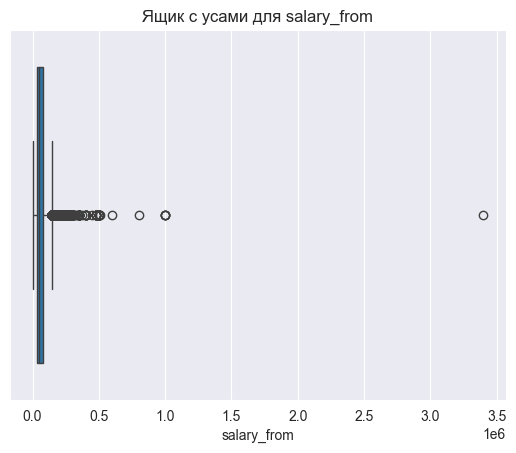

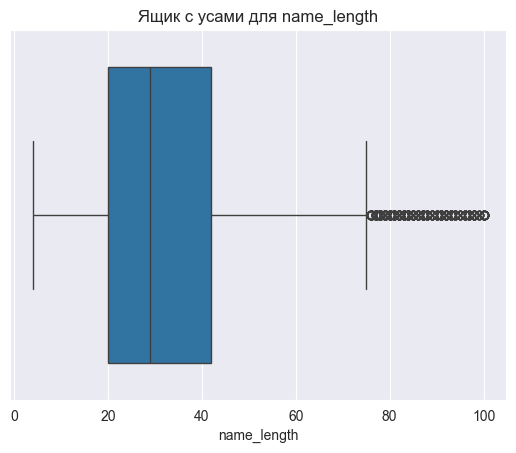

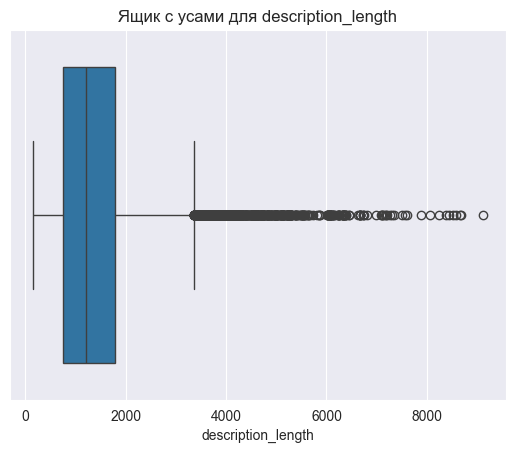

In [53]:
for feature in important_features:
    sns.boxplot(x=train_data[feature])
    plt.title(f"Ящик с усами для {feature}")
    plt.show()

In [54]:
X_train_for_salary_pred = train_data.drop('salary_from', axis=1)
y_train_for_salary_pred = train_data['salary_from']

X_train_split_sal, X_val_split_sal, y_train_split_sal, y_val_split_sal = train_test_split(X_train_for_salary_pred, y_train_for_salary_pred, test_size=0.2, random_state=42)

In [55]:
dtrain_sal = xgb.DMatrix(X_train_split_sal, label=y_train_split_sal)

params = {
    'objective': 'reg:squarederror',  
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'eval_metric': 'rmse'
}


model = xgb.train(params=params, dtrain=dtrain_sal, num_boost_round=300, verbose_eval=True)

In [56]:
model.save_model('xgb_model2.model')

/Users/rpopov/PycharmProjects/data_analysis/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:35:12] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [57]:
from sklearn.metrics import mean_squared_error

dtest = xgb.DMatrix(X_val_split_sal)
y_pred = model.predict(dtest)

mse = mean_squared_error(y_val_split_sal, y_pred)
print(f'Mean Squared Error (mse): {mse}')

Root Mean Absolute Error (mse): 758185540.1704068


In [58]:
loaded_model = xgb.Booster()
loaded_model.load_model('xgb_model2.model')

In [59]:
missing_data_train = df_train_encoded[df_train_encoded['salary_from'].isnull()]
X_missing_train = missing_data_train.drop('salary_from', axis=1)
predicted_values_train = model.predict(xgb.DMatrix(X_missing_train.drop(columns=['id'])))
df_train_encoded.loc[df_train_encoded['salary_from'].isnull(), 'salary_from'] = predicted_values_train

In [60]:
column_order = df_train_encoded.columns
df_test_encoded = df_test_encoded[column_order]

In [61]:
missing_data_test = df_test_encoded[df_test_encoded['salary_from'].isnull()]
X_missing_test = missing_data_test.drop('salary_from', axis=1)
predicted_values_test = model.predict(xgb.DMatrix(X_missing_test.drop(columns=['id'])))
df_test_encoded.loc[df_test_encoded['salary_from'].isnull(), 'salary_from'] = predicted_values_test

In [62]:
df_train_encoded.isna().sum()

id                          0
has_test                    0
response_letter_required    0
salary_from                 0
salary_gross                0
                           ..
published_hour              0
published_day_of_month      0
published_month             0
published_year              0
area_id_Other               0
Length: 995, dtype: int64

In [63]:
df_test_encoded['salary_from'].isna().sum()

0

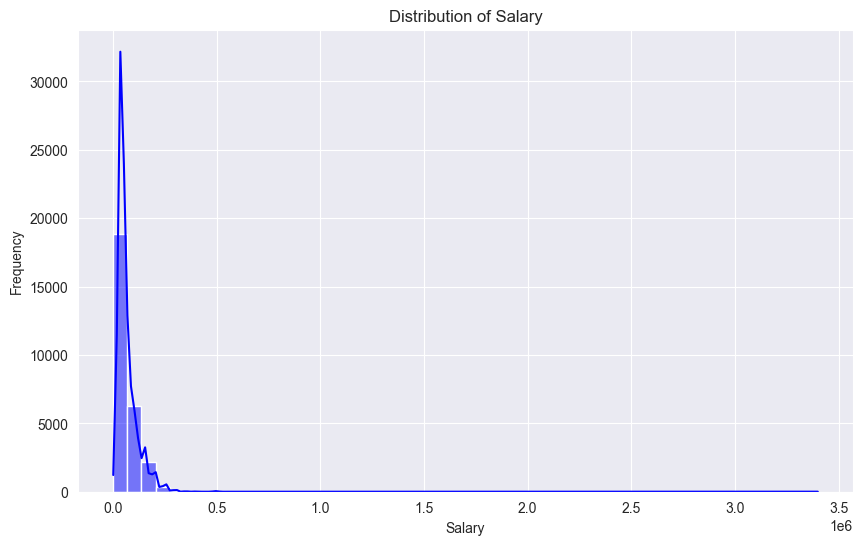

In [64]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train_encoded['salary_from'], bins=50, kde=True, color='blue')
plt.title('Distribution of Salary')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

In [65]:
df_train_encoded['salary_from'].describe()

count    2.778500e+04
mean     6.526809e+04
std      5.387171e+04
min      1.000000e+00
25%      3.450000e+04
50%      5.000000e+04
75%      8.000000e+04
max      3.400000e+06
Name: salary_from, dtype: float64

In [66]:
salary_bins = [0, 35000, 50000, 75000, 100000, 120000, 150000, float('inf')]
salary_labels = ['0-35000', '35001-50000', '50001-75000', '75001-100000', '100001-120000', '120001-150000', '150001+']

df_train_encoded.loc[:, 'salary_category'] = pd.cut(df_train_encoded['salary_from'], bins=salary_bins, labels=salary_labels, right=False)
salary_category_dummies_train = pd.get_dummies(df_train_encoded['salary_category'], prefix='salary')

df_test_encoded.loc[:,'salary_category'] = pd.cut(df_test_encoded['salary_from'], bins=salary_bins, labels=salary_labels, right=False)
salary_category_dummies_test = pd.get_dummies(df_test_encoded['salary_category'], prefix='salary')

df_train_encoded = pd.concat([df_train_encoded, salary_category_dummies_train], axis=1)
df_train_encoded.drop(columns=['salary_category'], inplace=True)

df_test_encoded = pd.concat([df_test_encoded, salary_category_dummies_test], axis=1)
df_test_encoded.drop(columns=['salary_category'], inplace=True)

In [67]:
df_train_encoded['description_to_salary_ratio'] = df_train_encoded['description_length'] / (df_train_encoded['salary_from'])

In [68]:
df_test_encoded['description_to_salary_ratio'] = df_test_encoded['description_length'] / (df_test_encoded['salary_from'])

In [69]:
column_order = df_train_encoded.columns
df_test_encoded = df_test_encoded[column_order]

In [70]:
df_train_encoded.dtypes

id                               int64
has_test                          bool
response_letter_required          bool
salary_from                    float64
salary_gross                      bool
                                ...   
salary_75001-100000              uint8
salary_100001-120000             uint8
salary_120001-150000             uint8
salary_150001+                   uint8
description_to_salary_ratio    float64
Length: 1003, dtype: object

In [71]:
df_test_encoded.dtypes

id                               int64
has_test                          bool
response_letter_required          bool
salary_from                    float64
salary_gross                      bool
                                ...   
salary_75001-100000              uint8
salary_100001-120000             uint8
salary_120001-150000             uint8
salary_150001+                   uint8
description_to_salary_ratio    float64
Length: 1003, dtype: object

In [72]:
merged_train = pd.merge(df_train_encoded, y_train, on='id')

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(merged_train.drop(columns=['id', 'salary_to']), merged_train['salary_to'], test_size=0.2, random_state=42)

features_to_scale_pred = ['salary_from', 'name_length', 'published_hour', 'published_year', 'published_month', 'published_day_of_month', 'published_day_of_week',  'description_to_salary_ratio']

ss = StandardScaler()
X_train_split[features_to_scale_pred] = ss.fit_transform(X_train_split[features_to_scale_pred])
X_val_split[features_to_scale_pred] = ss.transform(X_val_split[features_to_scale_pred])

In [73]:
df_test_encoded[features_to_scale_pred] = ss.transform(df_test_encoded[features_to_scale_pred])

In [74]:
def smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

smape_scorer = make_scorer(smape, greater_is_better=False)

In [75]:
param_dist_rf = {   
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
}


rf = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_depth=None)


rf.fit(X_train_split, y_train_split)

RandomForestRegressor(min_samples_leaf=2, n_estimators=300)

In [76]:
y_pred_for_csv = rf.predict(X_val_split)
smape_value = smape(y_val_split, y_pred_for_csv)
print("SMAPE on Test Set:", smape_value)

SMAPE on Test Set: 21.208020234279115


In [1644]:
y_res = rf.predict(df_test_encoded.drop(columns=['id']))
predictions_df = pd.DataFrame({'id': df_test_encoded['id'], 'salary_to': y_res})
predictions_df.to_csv('predictions_result.csv', index=False)